# Example: Continental rift

This example simulates the evolution of divergent margins, taking into account the plastic rheology and the sin-rift geodynamics.

The domain of the model comprises 1600 x 300 km<sup>2</sup>, composed of a regular mesh with square elements of 1 x 1 km<sup>2</sup>.
The boundary conditions for the velocity field simulate the lithospheric stretching
assuming a reference frame fixed on the lithospheric plate on the left side of the model,
and the plate on the right side moves rightward with a velocity of 1 cm/year.
The velocity field in the left and right boundaries of the model is chosen to ensure conservation of mass
and is symmetrical if the adopted reference frame movies to the right with a velocity of 0.5 cm/year relative to the left plate.
Additionally, free slip condition was assumed on the top and bottom of the numerical domain.
To simulate the free surface, the "sticky air" approach (e.g. Gerya and Yuen, 2003b) is adopted,
taking into account a 40-km thick layer with a relatively low viscosity material but with a compatible density with the atmospheric air.
The initial temperature structure is only depth dependent and is 0 ºC at the surface and 1300 ºC at the base of the lithosphere at 130 km.

To avoid artifacts created by a homogeneous rheology, a random perturbation of the initial strain in each finite element of the model (e.g. Brune et al., 2014) is applied.
This random perturbation follows a normal distribution in which the mean initial strain is 0.25 with a standard deviation of 0.08.
Additionally, to ensure the nucleation of rifting at the center of the numerical domain,
a weak seed (e.g. Huismans and Beaumont, 2003) is present in the lithospheric mantle with a constant initial strain of 0.3.


Brune S., Heine C., Pérez-Gussinyé M., Sobolev S. V., Rift migration explains continental margin asymmetry and crustal hyper-extension,
Nature communications, 2014, vol. 5, p. 1.

Gerya T. V., Yuen D. A., Characteristics-based marker-in-cell method with conservative finite-differences schemes for modeling geological flows with strongly variable transport properties, Physics of the Earth and Planetary Interiors, 2003a, vol. 140, p. 293

Huismans R. S., Beaumont C., Symmetric and asymmetric lithospheric extension: Relative effects of frictional-plastic and viscous strain softening, Journal of Geophysical Research: Solid Earth, 2003, vol. 108

## Generate input files

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

### Shape of the model

In [2]:
# Horizontal and vertical extent of the model in meters:
Lx, Lz = 1600.0e3, 300.0e3

# Number of points in horizontal and vertical direction:
Nx, Nz = 801,161 #1601, 301

In [3]:
x = np.linspace(0, Lx, Nx)
z = np.linspace(Lz, 0, Nz)

X, Z = np.meshgrid(x, z)

### Define the thickness of the layers

They are in meters.

In [4]:
# Sticky air layer:
thickness_sa = 40.0e3

# Lower crust:
thickness_lower_crust = 20.0e3

# Upper crust:
thickness_upper_crust = 20.0e3

# Lithosphere:
thickness_litho = 130.0e3

# Seed depth bellow base of lower crust
seed_depth = 13.0e3

### Create the interfaces (bottom first)

In [5]:
interfaces = {
    "litho": np.ones(Nx) * (thickness_litho + thickness_sa),
    "seed_base": np.ones(Nx) * (seed_depth + thickness_lower_crust + thickness_upper_crust + thickness_sa),
    "seed_top": np.ones(Nx) * (seed_depth + thickness_lower_crust + thickness_upper_crust + thickness_sa),
    "lower_crust": np.ones(Nx) * (thickness_lower_crust + thickness_upper_crust + thickness_sa),
    "upper_crust": np.ones(Nx) * (thickness_upper_crust + thickness_sa),
    "air": np.ones(Nx) * (thickness_sa),
}

Improve the seed layers:

In [6]:
# Seed thickness in meters:
thickness_seed = 6.0e3
# Seed horizontal position in meters:
x_seed = 750.0e3
# Number of points of horizontal extent
n_seed = 2

interfaces["seed_base"][
 int(Nx * x_seed // Lx - n_seed // 2) : int(Nx * x_seed // Lx + n_seed // 2)
] = (
    interfaces["seed_base"][
        int(Nx * x_seed // Lx - n_seed // 2) : int(Nx * x_seed // Lx + n_seed // 2)
    ]
    + thickness_seed // 2
)

interfaces["seed_top"][
    int(Nx * x_seed // Lx - n_seed // 2) : int(Nx * x_seed // Lx + n_seed // 2)
] = (
    interfaces["seed_top"][
        int(Nx * x_seed // Lx - n_seed // 2) : int(Nx * x_seed // Lx + n_seed // 2)
    ]
    - thickness_seed // 2
)

Plot the interfaces:

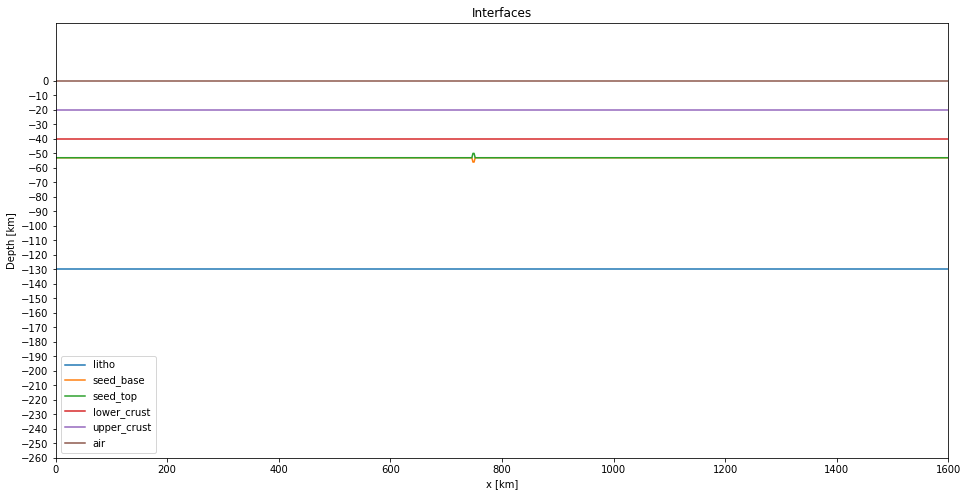

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))

for label, layer in interfaces.items():
    ax.plot(x / 1e3, (-layer + thickness_sa) / 1e3, label=f"{label}")

ax.set_yticks(np.arange(-Lz / 1e3, 1 / 1e3, 10))
ax.set_xlim([0, Lx/1000])
ax.set_ylim([(-Lz + thickness_sa) / 1e3, 0 + thickness_sa / 1e3])

ax.set_xlabel("x [km]")
ax.set_ylabel("Depth [km]")

plt.title("Interfaces")
plt.legend()

plt.show()

#### Create the interface file

The interface file contain the layer properties and the interface's depth between these layers. 

Layer properties:
* Compositional factor (C)
* Density (rho)
* Radiogenic heat (H)
* Pre-exponential scale factor (A)
* Power law exponent (n)
* Activation energy (Q)
* Activation volume (v)

In [8]:
# Define the radiogenic heat for the upper and lower crust in W/kg:
Huc = 2.5e-6 / 2700.0
Hlc = 0.8e-6 / 2800.0

# Create and save the interface file:
with open("interfaces.txt", "w") as f:
    layer_properties = f"""
        C   1.0       1.0        0.1        1.0        1.0         1.0         1.0
        rho 3378.0    3354.0     3354.0     3354.0     2800.0      2700.0      1.0
        H   0.0       9.0e-12    9.0e-12    9.0e-12    {Hlc}       {Huc}       0.0
        A   1.393e-14 2.4168e-15 2.4168e-15 2.4168e-15 8.574e-28   8.574e-28   1.0e-18
        n   3.0       3.5        3.5        3.5        4.0         4.0         1.0
        Q   429.0e3   540.0e3    540.0e3    540.0e3    222.0e3     222.0e3     0.0
        V   15.0e-6   25.0e-6    25.0e-6    25.0e-6    0.0         0.0         0.0
    """

    for line in layer_properties.split("\n"):
        line = line.strip()
        if len(line):
            f.write(" ".join(line.split()) + "\n")

    # layer interfaces
    data = -1 * np.array(tuple(interfaces.values())).T
    np.savetxt(f, data, fmt="%.1f")

### Create initial temperature field

The initial temperature structure is depth dependent and is 0°C at the surface and 1300°C at the base of the lithosphere at 130 km.
With these boundary conditions, the initial temperature structure in the interior of the lithosphere is given by the solution of the following equation:

$$ \kappa \frac{\partial^2 T(z)}{\partial z^2} + \frac{H(z)}{c_p} = 0$$

where $H(z)$ is the internal heat production of the different layers.

The sublithospheric temperature follows an adiabatic increase up to the bottom of the model:

$$T = T_p exp (g \alpha z ∕c_p)$$

Where $T_p$ is the potential temperature for the mantle, $g$ is the gravity aceletation, $\alpha$ is the volumetric expansion coefficient, $c_p$ is the specific heat capacity.

In [9]:
kappa = 1.0e-6 # m^2/s
ccapacity = 1250 # J/(kg K)
tem_p = 1262  # °C
g = -10 # m/s^2
alpha = 3.28e-5 # 1/K

In [10]:
# Temperature when z < 130 km:
temp_z = 1300 * (z - thickness_sa) / (thickness_litho)

# Sublithospheric temperature:
temp_adiabatic = tem_p / np.exp(g * alpha * (z - thickness_sa) / ccapacity)

temp_z[temp_z < 0.0] = 0.0
temp_z[temp_z > temp_adiabatic] = temp_adiabatic[temp_z > temp_adiabatic]

Now, we will apply the thermal diffusivity in the model.

Create the internal heat production model:

In [11]:
H = np.zeros_like(temp_z)

# Add the H value for the upper crust:
cond = (z >= thickness_sa) & (z < thickness_upper_crust + thickness_sa)
H[cond] = Huc

# Add the H value for the lower crust:
cond = (z >= thickness_upper_crust + thickness_sa) & (
    z < thickness_lower_crust + thickness_upper_crust + thickness_sa
)   # lower crust
H[cond] = Hlc

In [12]:
Taux = np.copy(temp_z)
t = 0
dt = 10000
dt_sec = dt * 365 * 24 * 3600
cond = (z > thickness_sa + thickness_litho) | (temp_z == 0)
dz = Lz / (Nz - 1)

# Apply the thermal diffusivity
while t < 500.0e6:
    temp_z[1:-1] += (
        kappa * dt_sec * ((temp_z[2:] + temp_z[:-2] - 2 * temp_z[1:-1]) / dz ** 2)
        + H[1:-1] * dt_sec / ccapacity
    )
    temp_z[cond] = Taux[cond]
    t = t + dt

Save initial temperature file:

In [13]:
temp_z = np.ones_like(X) * temp_z[:, None]

print(np.shape(temp_z))

# Save the initial temperature file
np.savetxt(
    "input_temperature_0.txt", 
    np.reshape(temp_z, (Nx * Nz)), 
    header="T1\nT2\nT3\nT4"
)

(161, 801)


Plot the temperature model:

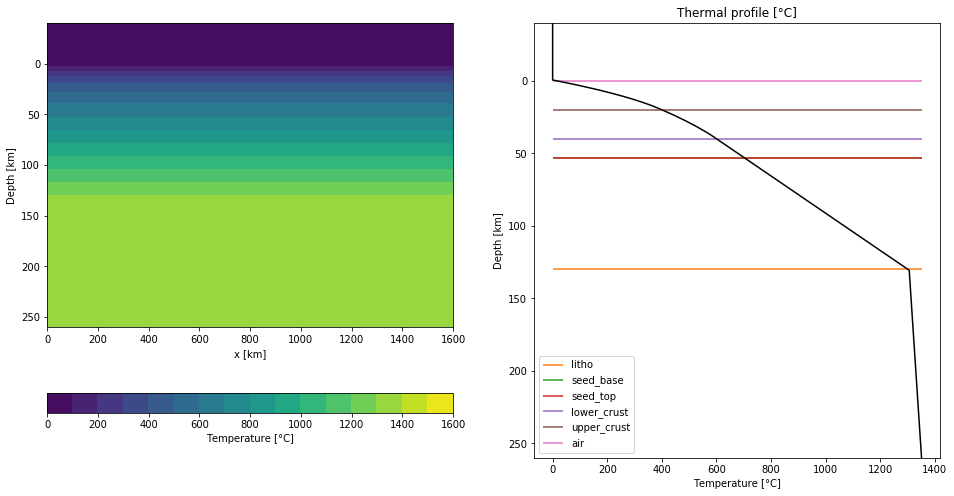

In [14]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# Temperature field:
im1 = ax0.contourf(
    X / 1.0e3,
    (Z - thickness_sa) / 1.0e3,
    temp_z,
    levels=np.arange(0, 1610, 100)
    )

ax0.set_ylim((Lz - thickness_sa) / 1.0e3, -thickness_sa / 1e3)
ax0.set_ylabel("Depth [km]")
ax0.set_xlabel("x [km]")
cbar = fig.colorbar(im1, orientation='horizontal', ax=ax0)
cbar.set_label("Temperature [°C]")

# Profile:
ax1.set_title("Thermal profile [°C]")
ax1.plot(temp_z[:, 0], (z - thickness_sa) / 1.0e3, "-k")
# Add interfaces:
code = 0
for label in list(interfaces.keys()):
    code += 1
    color = "C" + str(code)
    ax1.hlines(
        (interfaces[label][0] - thickness_sa) / 1.0e3,
        np.min(temp_z[:, 0]),
        np.max(temp_z[:, 0]),
        label=f"{label}",
        color=color,
    )

ax1.set_ylim((Lz - thickness_sa) / 1.0e3, -thickness_sa / 1e3)
ax1.set_xlabel("Temperature [°C]")
ax1.set_ylabel("Depth [km]")

plt.legend(loc="lower left")
plt.show()

### Boundary condition - Velocity

The horizontal velocity field along the left and right borders of the domain presents two layers:
* Constant velocity with depth at $0 ≤ z < h_c$
* Linearly variable velocity with depth at $h_c ≤ z ≤ h_c + h_a$

where $h_c = 150$ km is the thickness of the upper layer with constant velocity, corresponding to the lithosphere $h_{litho} = 130$ km and part of the asthenosphere, and $h_a = 110$ km corresponds to the remaining asthenospheric portion of the model until the bottom
of the model, where the horizontal velocity at the borders of the model varies linearly with depth.
Therefore, the sum $h_c + h_a$ represents the total thickness of the model without the “sticky air” layer.

In [15]:
# Convert 1 cm/year to m/s:
velocity_L = 0.005 / (365 * 24 * 3600)

# Define the thickness with constant velocity in meters
thickness_v_const = 150.0e3

thickness_a = Lz - thickness_sa - thickness_v_const

velocity_R = 2 * velocity_L * (thickness_v_const + thickness_a) / thickness_a

fac_air = 10.0e3

In [16]:
# Create  horizontal and vertical velocity:
VX, VZ = np.zeros_like(X), np.zeros_like(X)

Velocity for the left side (`x == 0`):

In [17]:
# When 0 <= z <= (h_v_const + thickness_sa), VX is zero.
# When (h_v_const * thickness_sa) <= z <= Lz, VX goes from 0 to vR.
cond = (Z > thickness_v_const + thickness_sa) & (X == 0)
VX[cond] = velocity_R * (Z[cond] - thickness_v_const - thickness_sa) / thickness_a

Velocity for the right side (`x == Lx`):

In [18]:
# When 0 <= z <= (h_v_const + thickness_sa), VX is 2vL
# When (h_v_const + thickness_sa) < z <= Lz, VX goes from 2vL to -vR + 2vL
cond = (Z > thickness_v_const + thickness_sa) & (X == Lx)
VX[cond] = -velocity_R * (Z[cond] - thickness_v_const - thickness_sa) / thickness_a

VX[X == Lx] += 2 * velocity_L

VX[Z <= thickness_sa - fac_air] = 0

Due to the mass conservation is assumed, the sum of the integrals over the boundaries (material flow) must be zero.

In [19]:
# For the left side:
v0= VX[(X == 0)]
sum_velocity_left = np.sum(v0[1:-1]) + (v0[0] + v0[-1]) / 2.0

# For the right side:
vf = VX[(X == Lx)]
sum_velocity_right = np.sum(vf[1:-1]) + (vf[0] + vf[-1]) / 2.0

dz = Lz / (Nz - 1)
diff = (sum_velocity_right - sum_velocity_left) * dz

print("Sum of the integrals over the boundary is:", diff)

Sum of the integrals over the boundary is: 2.868376715473532e-06


If the sum of the integrals over the boundaries is not zero, because rounding errors, we add a very small flow on the top to compensate this difference.
In fact this is a very small correction.

In [20]:
vv = -diff / Lx

VZ[Z == 0] = vv

Create and save the initial velocity file:

In [21]:
VVX = np.copy(np.reshape(VX, Nx * Nz))
VVZ = np.copy(np.reshape(VZ, Nx * Nz))

velocity = np.zeros((2, Nx * Nz))

velocity[0, :] = VVX
velocity[1, :] = VVZ

velocity = np.reshape(velocity.T, (np.size(velocity)))

np.savetxt("input_velocity_0.txt", velocity, header="v1\nv2\nv3\nv4")

Plot the velocity profile for the boundaries:

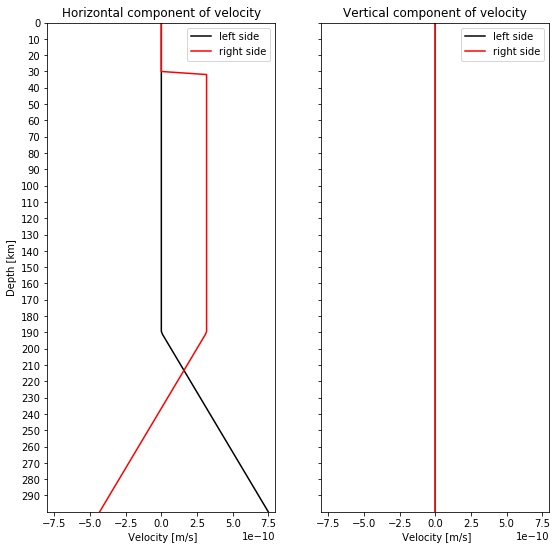

In [22]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(9, 9), sharey=True)

ax0.plot(VX[:, 0], (z) / 1e3, "k-", label="left side")
ax1.plot(VZ[:, 0], (z) / 1e3, "k-", label="left side")

ax0.plot(VX[:, -1], (z ) / 1e3, "r-", label="right side")
ax1.plot(VZ[:, -1], (z) / 1e3, "r-", label="right side")

ax0.legend()
ax1.legend()

ax0_xlim = ax0.get_xlim()
ax1_xlim = ax1.get_xlim()

ax0.set_yticks(np.arange(-40, Lz / 1e3, 10))
#ax1.set_yticks(np.arange(0, Lz / 1000, 20))

ax0.set_ylim([Lz / 1e3 , 0])


ax0.set_xlim([-8e-10, 8e-10])
ax1.set_xlim([-8e-10, 8e-10])

ax0.set_xlabel(" Velocity [m/s]")
ax1.set_xlabel(" Velocity [m/s]")
ax0.set_ylabel("Depth [km]")

ax0.set_title("Horizontal component of velocity")
ax1.set_title("Vertical component of velocity")

plt.show()

### Create the parameter file

In [28]:
params = f"""
nx = {Nx}
nz = {Nz}
lx = {Lx}
lz = {Lz}


# Simulation options
multigrid                           = 1             # ok -> soon to be on the command line only
solver                              = iterative        # default is direct [direct/iterative]
denok                               = 1.0e-5       #Mod # default is 1.0E-4
particles_per_element               = 40          # default is 81
particles_perturb_factor            = 0.7           # default is 0.5 [values are between 0 and 1]
rtol                                = 1.0e-7        #Mod# the absolute size of the residual norm (relevant only for iterative methods), default is 1.0E-5
RK4                                 = Euler         # default is Euler [Euler/Runge-Kutta]
Xi_min                              = 1.0e-7       # default is 1.0E-14
random_initial_strain               = 0.3           # default is 0.0
pressure_const                      = -1.0          # default is -1.0 (not used) - useful only in horizontal 2D models
initial_dynamic_range               = True         # default is False [True/False]
periodic_boundary                   = False         # default is False [True/False]
high_kappa_in_asthenosphere         = False         # default is False [True/False]
K_fluvial                           = 2.0e-7        # default is 2.0E-7
m_fluvial                           = 1.0           # default is 1.0
sea_level                           = 0.0           # default is 0.0
basal_heat                          = 0.0          # default is -1.0

# Surface processes
sp_surface_tracking                 = False         # default is False [True/False]
sp_surface_processes                = False         # default is False [True/False]
sp_dt                               = 1.0e5        # default is 0.0
sp_d_c                              = 1.0          # default is 0.0
plot_sediment                       = False         # default is False [True/False]
a2l                                 = True          # default is True [True/False]

free_surface_stab                   = True          # default is True [True/False]
theta_FSSA                          = 0.5           # default is 0.5 (only relevant when free_surface_stab = True)

# Time constrains
step_max                            = 5000          # Maximum time-step of the simulation
time_max                            = 100.0e6     # Maximum time of the simulation [years]
dt_max                              = 10.0e3      # Maximum time between steps of the simulation [years]
step_print                          = 10            # Make file every <step_print>
sub_division_time_step              = 0.5           # default is 1.0
initial_print_step                  = 0             # default is 0
initial_print_max_time              = 1.0e6         # default is 1.0E6 [years]

# Viscosity
viscosity_reference                 = 1.0e26        # Reference viscosity [Pa.s]
viscosity_max                       = 1.0e25        # Maximum viscosity [Pa.s]
viscosity_min                       = 1.0e18        # Minimum viscosity [Pa.s]
viscosity_per_element               = constant      # default is variable [constant/variable]
viscosity_mean_method               = arithmetic      # default is harmonic [harmonic/arithmetic]
viscosity_dependence                = pressure      # default is depth [pressure/depth]

# External ASCII inputs/outputs
interfaces_from_ascii               = True          # default is False [True/False]
n_interfaces                        = {len(interfaces.keys())}           # Number of interfaces int the interfaces.txt file
variable_bcv                        = False         # default is False [True/False]
temperature_from_ascii              = True         # default is False [True/False]
velocity_from_ascii                 = True         # default is False [True/False]
binary_output                       = False         # default is False [True/False]
sticky_blanket_air                  = True         # default is False [True/False]
precipitation_profile_from_ascii    = False         # default is False [True/False]
climate_change_from_ascii           = False         # default is False [True/False]


print_step_files                    = True          # default is True [True/False]
checkered                           = False         # Print one element in the print_step_files (default is False [True/False])

sp_mode                             = 5             # default is 1 [0/1/2]

geoq                                = on            # ok
geoq_fac                            = 100.0           # ok

# Physical parameters
temperature_difference              = 1500.         # ok
thermal_expansion_coefficient       = 3.28e-5       # ok
thermal_diffusivity_coefficient     = 1.0e-6        # ok
gravity_acceleration                = 10.0          # ok
density_mantle                      = 3300.         # ok
external_heat                       = 0.0e-12       # ok
heat_capacity                       = 1250.         # ok

non_linear_method                   = on            # ok
adiabatic_component                 = on            # ok
radiogenic_component                = on            # ok

# Velocity boundary conditions
top_normal_velocity                 = fixed         # ok
top_tangential_velocity             = free          # ok
bot_normal_velocity                 = fixed         # ok
bot_tangential_velocity             = free          # ok
left_normal_velocity                = fixed         # ok
left_tangential_velocity            = fixed         # ok
right_normal_velocity               = fixed         # ok
right_tangential_velocity           = fixed         # ok

surface_velocity                    = 0.0e-2        # ok
multi_velocity                      = False         # default is False [True/False]

# Temperature boundary conditions
top_temperature                     = fixed         # ok
bot_temperature                     = fixed         # ok
left_temperature                    = fixed          # ok
right_temperature                   = fixed          # ok

rheology_model                      = 9             # ok
T_initial                           = 3             # ok

nondimensionalization               = True


"""
# Create the parameter file
with open("param.txt", "w") as f:
    for line in params.split("\n"):
        line = line.strip()
        if len(line):
            f.write(" ".join(line.split()) + "\n")


## Run the model 

In this example, mandyoc use the following flags: 

* -seed 0,2
* -strain_seed 0.0,1.0 

You can run the model as:

```
mpirun -n NUMBER_OF_CORES mandyoc -seed 0,2 -strain_seed 0.0,1.0 
```

*You have to change NUMBER_OF_CORES.*

## Post-processing

### Plot the results

Determine the initial and final step to make the plots:

In [24]:
step_initial = 0
step_final = 5000

d_step = 1000

Load the parameter file to generate the grid of the model:

In [25]:
with open("param.txt", "r") as f:
    line = f.readline()
    line = line.split()
    Nx = int(line[2])
    line = f.readline()
    line = line.split()
    Nz = int(line[2])
    line = f.readline()
    line = line.split()
    Lx = float(line[2])
    line = f.readline()
    line = line.split()
    Lz = float(line[2])

print(
    "nx:", Nx, "\n",
    "nz:", Nz, "\n",
    "Lx:", Lx, "\n",
    "Lz:", Lz
)

nx: 1601 
 nz: 301 
 Lx: 1600000.0 
 Lz: 300000.0


Create the grid in kilometers:

In [26]:
xi = np.linspace(0, Lx / 1e3, Nx)
zi = np.linspace(-Lz / 1e3, 0, Nz)

xx, zz = np.meshgrid(xi, zi)

In [27]:
# Define the thickness of the air layer in kilometers
thickness_air = 40.0

Plot the results:

Step = 0
Time = 0.0 Myr


strain(log) -inf -0.00412272081167139
strain 0.0 0.990552


/tmp/ipykernel_17755/2177167732.py:34: RuntimeWarning: divide by zero encountered in log10
  strain_log = np.log10(strain)


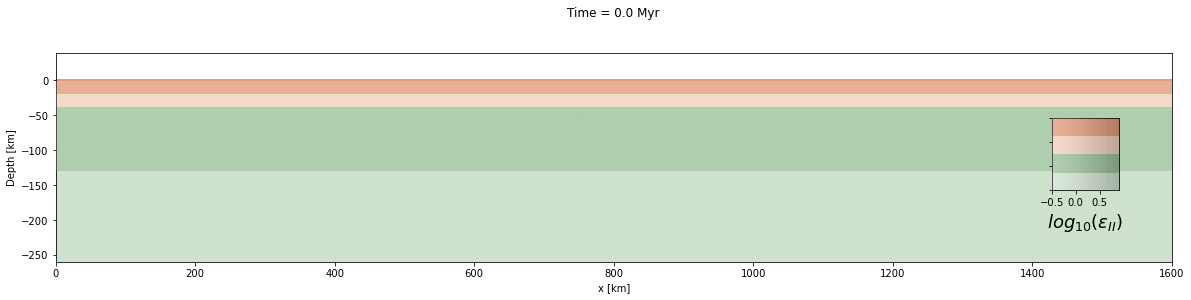

Step = 1000
Time = 8.5 Myr


strain(log) -inf 0.2504322014207584
strain 0.0 1.78005


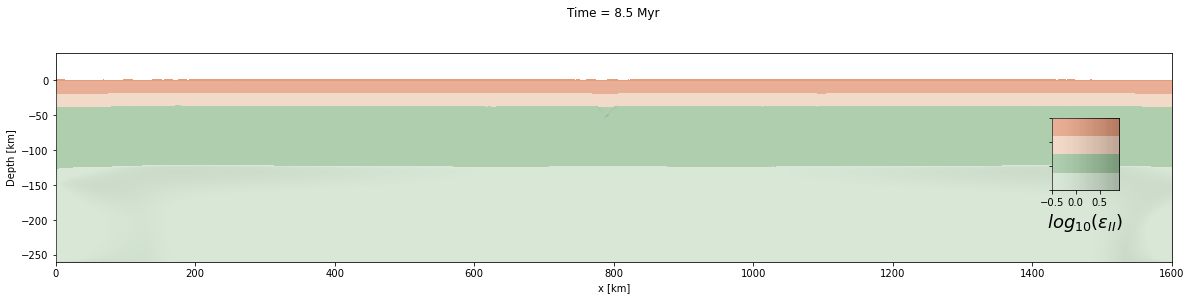

Step = 2000
Time = 16.9 Myr


strain(log) -inf 1.0109653083672
strain 0.0 10.2557


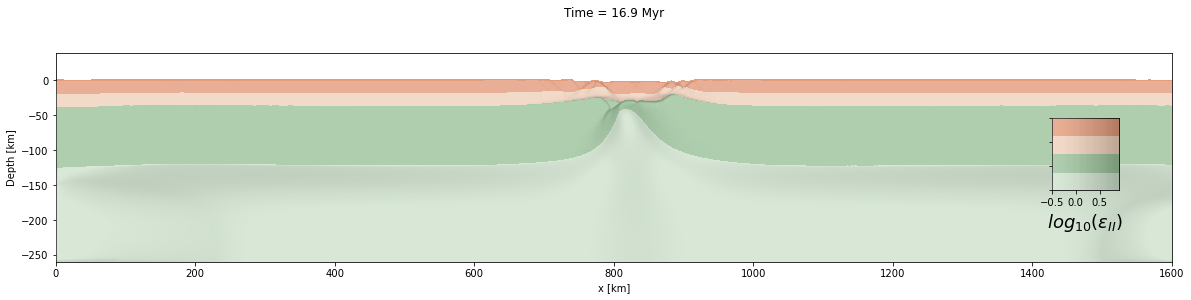

Step = 3000
Time = 25.4 Myr


strain(log) -inf 0.9940050701628806
strain 0.0 9.86291


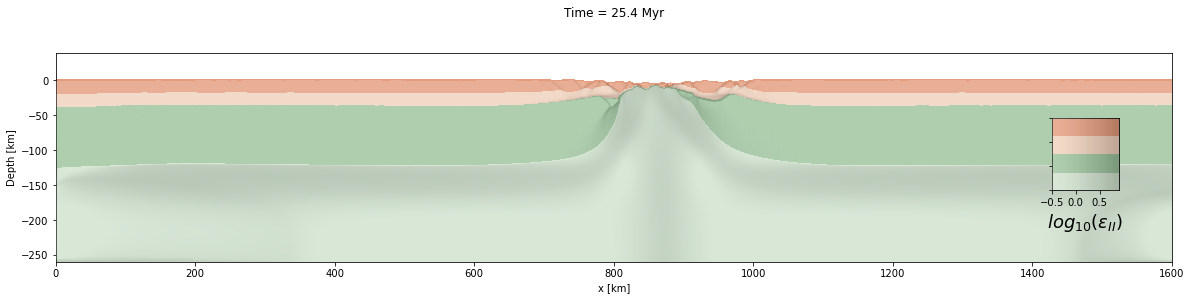

Step = 4000
Time = 33.8 Myr


strain(log) -inf 1.0163103055955254
strain 0.0 10.3827


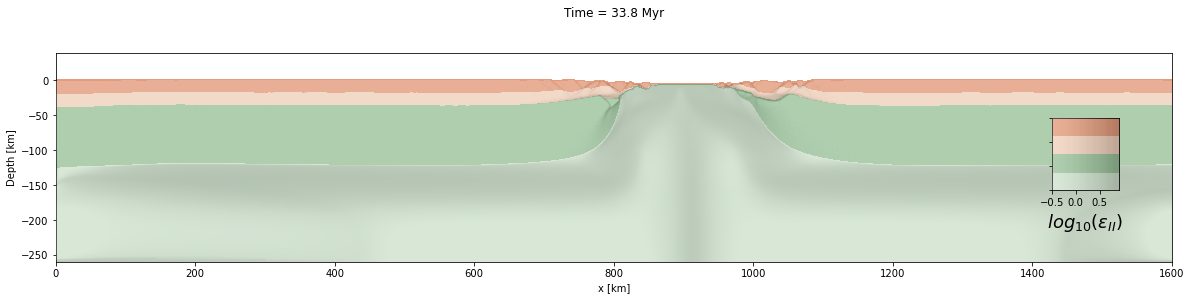

Step = 5000
Time = 42.3 Myr


strain(log) -inf 1.0119508660593983
strain 0.0 10.279


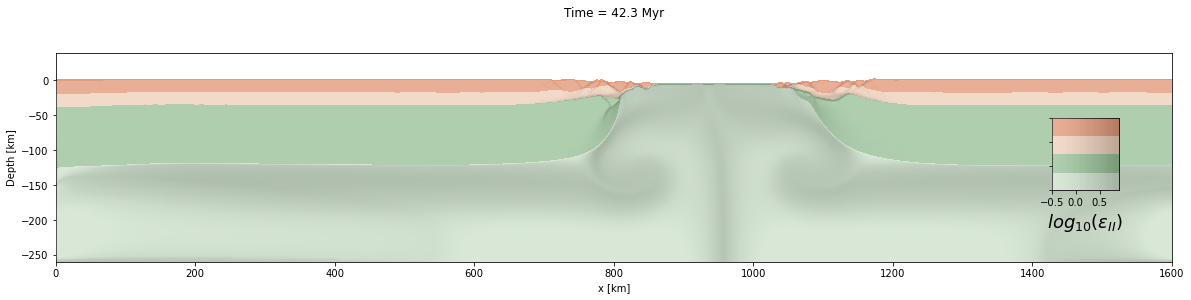

In [28]:
for cont in range(step_initial, step_final + d_step, d_step):  
    
    # Read time
    time = np.loadtxt("time_" + str(cont) + ".txt", dtype="str")
    time = time[:, 2:]
    time = time.astype("float")
   
    # Read density
    rho = pd.read_csv(
        "density_" + str(cont) + ".txt",
        delimiter=" ",
        comment="P",
        skiprows=2,
        header=None,
    )
    rho = rho.to_numpy()
    rho[np.abs(rho) < 1.0e-200] = 0
    rho = np.reshape(rho, (Nx, Nz), order="F")
    rho = np.transpose(rho)
    
    # Read strain
    strain = pd.read_csv(
        "strain_" + str(cont) + ".txt",
        delimiter=" ",
        comment="P",
        skiprows=2,
        header=None,
    )
    strain = strain.to_numpy()
    strain[np.abs(strain) < 1.0e-200] = 0
    strain = np.reshape(strain, (Nx, Nz), order="F")
    strain = np.transpose(strain)
    strain[rho < 200] = 0
    strain_log = np.log10(strain)
    
    print("Step =", cont)
    print("Time = %.1lf Myr\n\n" % (time[0] / 1.0e6))
    print("strain(log)", np.min(strain_log), np.max(strain_log))
    print("strain", np.min(strain), np.max(strain))
    
    plt.figure(figsize=(20, 5))
    plt.title("Time = %.1lf Myr\n\n" % (time[0] / 1.0e6))

    # Create the colors to plot the density
    cr = 255.0
    color_upper_crust = (228.0 / cr, 156.0 / cr, 124.0 / cr)
    color_lower_crust = (240.0 / cr, 209.0 / cr, 188.0 / cr)
    color_lithosphere = (155.0 / cr, 194.0 / cr, 155.0 / cr)
    color_asthenosphere = (207.0 / cr, 226.0 / cr, 205.0 / cr)
    colors = [
        color_upper_crust, 
        color_lower_crust, 
        color_lithosphere, 
        color_asthenosphere
    ]
    # Plot density
    plt.contourf(
        xx,
        zz + thickness_air,
        rho,
        levels=[200.0, 2750, 2900, 3365, 3900],
        colors=colors,
    )  
    
    # Plot strain_log
    plt.imshow(
        strain_log[::-1, :],
        extent=[0, Lx / 1e3, -Lz / 1e3 + thickness_air, thickness_air],
        zorder=100,
        alpha=0.2,
        cmap=plt.get_cmap("Greys"),
        vmin=-0.5,
        vmax=0.9,
    )
    plt.xlabel("x [km]")
    plt.ylabel("Depth [km]")
    
    b1 = [0.74, 0.41, 0.2, 0.2]
    bv1 = plt.axes(b1)

    A = np.zeros((100, 10))

    A[:25, :] = 2700
    A[25:50, :] = 2800
    A[50:75, :] = 3300
    A[75:100, :] = 3400

    A = A[::-1, :]

    xA = np.linspace(-0.5, 0.9, 10)
    yA = np.linspace(0, 1.5, 100)

    xxA, yyA = np.meshgrid(xA, yA)
    air_threshold = 200
    plt.contourf(
        xxA,
        yyA,
        A,
        levels=[air_threshold, 2750, 2900, 3365, 3900],
        colors=colors,
    )

    plt.imshow(
        xxA[::-1, :],
        extent=[-0.5, 0.9, 0, 1.5],
        zorder=100,
        alpha=0.2,
        cmap=plt.get_cmap("Greys"),
        vmin=-0.5,
        vmax=0.9,
    )

    bv1.set_yticklabels([])
    
    plt.xlabel("$log_{10}(\epsilon_{II})$", size=18)

    plt.show()